## Imports

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow import string as tf_string
from tensorflow.keras.layers import TextVectorization
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Bidirectional, Dense, Dropout
from tensorflow.keras.layers import Embedding, Flatten
from tensorflow.keras.optimizers import Adam

from sklearn.model_selection import train_test_split #
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report, precision_score, recall_score
from sklearn.preprocessing import normalize, OneHotEncoder



## Načítanie dát

In [ ]:
dataset = pd.read_csv('../Data/final_dataset_4.csv')

## Rozdelenie dát

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(dataset['processed_text'], dataset['author_id'], test_size=0.20, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

## One-hot encoding

In [ ]:
one_hot_encoder = OneHotEncoder()

y_train = one_hot_encoder.fit_transform(y_train.to_numpy().reshape(-1, 1)).toarray()
y_valid = one_hot_encoder.transform(y_valid.to_numpy().reshape(-1, 1)).toarray()
y_test = one_hot_encoder.transform(y_test.to_numpy().reshape(-1, 1)).toarray()

## TextVectorization

In [ ]:
embedding_dim = 512
vocab_size = 90000
sequence_length = 9000

vect_layer = TextVectorization(max_tokens=vocab_size, output_mode='int', output_sequence_length=sequence_length)
vect_layer.adapt(dataset['processed_text'].values)

### Model 1 - LSTM+GRU

In [ ]:
input_layer = keras.layers.Input(shape=(1,), dtype=tf_string)
x_v = vect_layer(input_layer)
emb = keras.layers.Embedding(vocab_size, embedding_dim)(x_v)
x = keras.layers.LSTM(256, return_sequences=True)(emb)
x = keras.layers.Dropout(0.1)(x)
x = keras.layers.GRU(128, return_sequences=True)(x)
x = keras.layers.Flatten()(x)
x = keras.layers.Dropout(0.1)(x)
x = keras.layers.Dense(64, 'relu')(x)
x = keras.layers.Dense(32, 'relu')(x)
x = keras.layers.Dropout(0.1)(x)
output_layer = keras.layers.Dense(y_train.shape[1], activation='softmax')(x)


model = keras.Model(input_layer, output_layer)
model.summary()

optimizer = Adam(learning_rate=0.001)

model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVe  (None, 9000)              0         
 ctorization)                                                    
                                                                 
 embedding (Embedding)       (None, 9000, 512)         46080000  
                                                                 
 lstm (LSTM)                 (None, 9000, 256)         787456    
                                                                 
 dropout (Dropout)           (None, 9000, 256)         0         
                                                                 
 gru (GRU)                   (None, 9000, 128)         148224    
                                                             

In [ ]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='weights.best.tf.weights.h5',
    save_weights_only=True,
    monitor='val_loss',
    mode='auto',
    save_best_only=True)

In [ ]:
history = model.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=10, batch_size = 8, callbacks=[model_checkpoint_callback])

Epoch 1/10
109/109 [==============================] - 97s 821ms/step - loss: 3.4354 - accuracy: 0.0804 - val_loss: 2.8858 - val_accuracy: 0.1443
Epoch 2/10
109/109 [==============================] - 82s 755ms/step - loss: 2.9219 - accuracy: 0.0987 - val_loss: 2.8389 - val_accuracy: 0.0825
Epoch 3/10
109/109 [==============================] - 74s 678ms/step - loss: 2.8594 - accuracy: 0.0930 - val_loss: 2.8691 - val_accuracy: 0.0825
Epoch 4/10
109/109 [==============================] - 76s 694ms/step - loss: 2.9519 - accuracy: 0.0918 - val_loss: 2.9990 - val_accuracy: 0.0412
Epoch 5/10
109/109 [==============================] - 73s 669ms/step - loss: 2.9967 - accuracy: 0.0505 - val_loss: 2.9997 - val_accuracy: 0.0412
Epoch 6/10
109/109 [==============================] - 76s 696ms/step - loss: 2.9949 - accuracy: 0.0448 - val_loss: 3.0011 - val_accuracy: 0.0412
Epoch 7/10
109/109 [==============================] - 75s 688ms/step - loss: 2.9960 - accuracy: 0.0528 - val_loss: 3.0021 - val_ac

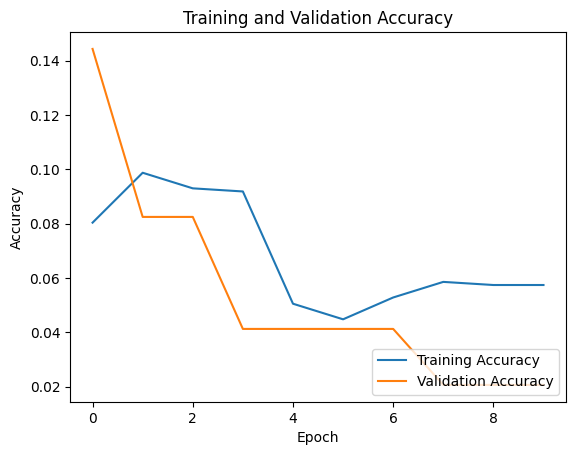

In [ ]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.show()

In [ ]:
model.evaluate(X_test, y_test)
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
y_test_ = np.argmax(y_test, axis=1)

8/8 [==============================] - 4s 404ms/step


In [ ]:
accuracy_sc = accuracy_score(y_pred=y_pred,y_true=y_test_)
f1_sc = f1_score(y_pred=y_pred, y_true=y_test_, average='weighted')
precision_sc = precision_score(y_pred=y_pred, y_true=y_test_, average='weighted', zero_division = 0)
recall_sc = recall_score(y_pred=y_pred, y_true=y_test_, average='weighted')

print(f"Accuracy: {accuracy_sc}")
print(f"F1 Score: {f1_sc}")
print(f"Precision: {precision_sc}")
print(f"Recall: {recall_sc}")

Accuracy: 0.0371900826446281
F1 Score: 0.002667017878897633
Precision: 0.001383102247114268
Recall: 0.0371900826446281


### Model 2 - BIDIRECTIONAL LSTM

In [ ]:
input_layer = keras.layers.Input(shape=(1,), dtype=tf_string)
x_v = vect_layer(input_layer)
emb = keras.layers.Embedding(vocab_size, embedding_dim)(x_v)
x = keras.layers.Bidirectional(keras.layers.LSTM(128, return_sequences=True))(emb)
x = keras.layers.GlobalAveragePooling1D()(x)
x = keras.layers.Dense(256, 'relu')(x)
x = keras.layers.Dropout(0.2)(x)
x = keras.layers.Dense(128, 'relu')(x)
x = keras.layers.Dropout(0.2)(x)
output_layer = keras.layers.Dense(y_train.shape[1], activation='softmax')(x)

model = keras.Model(input_layer, output_layer)
model.summary()

optimizer = Adam(learning_rate=0.001)

model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVe  (None, 9000)              0         
 ctorization)                                                    
                                                                 
 embedding_1 (Embedding)     (None, 9000, 512)         46080000  
                                                                 
 bidirectional (Bidirection  (None, 9000, 256)         656384    
 al)                                                             
                                                                 
 global_average_pooling1d (  (None, 256)               0         
 GlobalAveragePooling1D)                                         
                                                           

In [ ]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='weights.best.tf.weights.h5',
    save_weights_only=True,
    monitor='val_loss',
    mode='auto',
    save_best_only=True)

stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

In [ ]:
history = model.fit(X_train, y_train, validation_data=(X_valid, y_valid), callbacks=[model_checkpoint_callback, stop], epochs=10, batch_size=8)

Epoch 1/10
109/109 [==============================] - 81s 702ms/step - loss: 2.8383 - accuracy: 0.0666 - val_loss: 2.7457 - val_accuracy: 0.0619
Epoch 2/10
109/109 [==============================] - 73s 671ms/step - loss: 2.4544 - accuracy: 0.1584 - val_loss: 2.3920 - val_accuracy: 0.1753
Epoch 3/10
109/109 [==============================] - 73s 668ms/step - loss: 1.9158 - accuracy: 0.2767 - val_loss: 2.0490 - val_accuracy: 0.2474
Epoch 4/10
109/109 [==============================] - 75s 691ms/step - loss: 1.5411 - accuracy: 0.4202 - val_loss: 1.8649 - val_accuracy: 0.3093
Epoch 5/10
109/109 [==============================] - 72s 664ms/step - loss: 1.2771 - accuracy: 0.4937 - val_loss: 1.4057 - val_accuracy: 0.4948
Epoch 6/10
109/109 [==============================] - 73s 667ms/step - loss: 0.9201 - accuracy: 0.6429 - val_loss: 1.1843 - val_accuracy: 0.6186
Epoch 7/10
109/109 [==============================] - 73s 665ms/step - loss: 0.6343 - accuracy: 0.7681 - val_loss: 1.0881 - val_ac

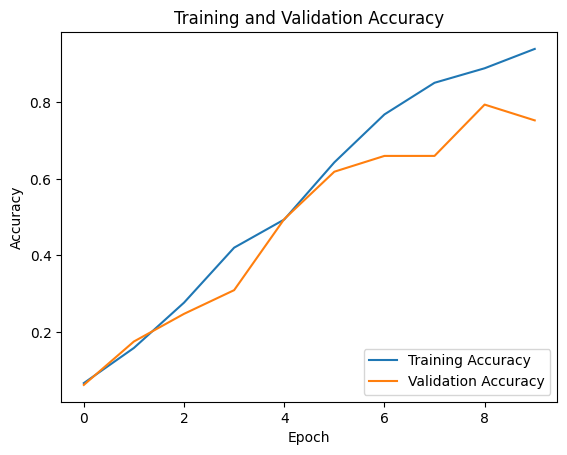

In [ ]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.show()

In [ ]:
model.evaluate(X_test, y_test)
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
y_test_ = np.argmax(y_test, axis=1)

8/8 [==============================] - 3s 305ms/step


In [ ]:
accuracy_sc = accuracy_score(y_pred=y_pred,y_true=y_test_)
f1_sc = f1_score(y_pred=y_pred, y_true=y_test_, average='weighted')
precision_sc = precision_score(y_pred=y_pred, y_true=y_test_, average='weighted', zero_division = 0)
recall_sc = recall_score(y_pred=y_pred, y_true=y_test_, average='weighted')

print(f"Accuracy: {accuracy_sc}")
print(f"F1 Score: {f1_sc}")
print(f"Precision: {precision_sc}")
print(f"Recall: {recall_sc}")

Accuracy: 0.8760330578512396
F1 Score: 0.8738487142848207
Precision: 0.8865335222990726
Recall: 0.8760330578512396


### Model 3 - LSTM

In [ ]:
input_layer = keras.layers.Input(shape=(1,), dtype=tf_string)
x_v = vect_layer(input_layer)
emb = keras.layers.Embedding(vocab_size, embedding_dim)(x_v)
x = keras.layers.LSTM(128, return_sequences=True)(emb)
x = keras.layers.Dropout(0.2)(x)
x = keras.layers.LSTM(64)(x)
x = keras.layers.Dropout(0.2)(x)
x = keras.layers.Dense(64, 'relu')(x)
x = keras.layers.Dropout(0.2)(x)
output_layer = keras.layers.Dense(y_train.shape[1], activation='softmax')(x)

model = keras.Model(input_layer, output_layer)
model.summary()

optimizer = Adam(learning_rate=0.001)

model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVe  (None, 9000)              0         
 ctorization)                                                    
                                                                 
 embedding_2 (Embedding)     (None, 9000, 512)         46080000  
                                                                 
 lstm_2 (LSTM)               (None, 9000, 128)         328192    
                                                                 
 dropout_5 (Dropout)         (None, 9000, 128)         0         
                                                                 
 lstm_3 (LSTM)               (None, 64)                49408     
                                                           

In [ ]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='weights.best.tf.weights.h5',
    save_weights_only=True,
    monitor='val_loss',
    mode='auto',
    save_best_only=True)

stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

In [ ]:
history = model.fit(X_train, y_train, validation_data=(X_valid, y_valid), callbacks=[model_checkpoint_callback, stop], epochs=10, batch_size=8)

Epoch 1/10
109/109 [==============================] - 70s 609ms/step - loss: 2.9334 - accuracy: 0.0746 - val_loss: 2.9209 - val_accuracy: 0.0412
Epoch 2/10
109/109 [==============================] - 66s 605ms/step - loss: 2.8246 - accuracy: 0.0884 - val_loss: 2.8717 - val_accuracy: 0.0412
Epoch 3/10
109/109 [==============================] - 63s 578ms/step - loss: 2.6672 - accuracy: 0.1481 - val_loss: 2.9564 - val_accuracy: 0.0619
Epoch 4/10
109/109 [==============================] - 65s 596ms/step - loss: 2.3911 - accuracy: 0.2503 - val_loss: 3.0954 - val_accuracy: 0.0412
Epoch 5/10
109/109 [==============================] - 65s 593ms/step - loss: 2.1357 - accuracy: 0.3157 - val_loss: 3.1022 - val_accuracy: 0.0722


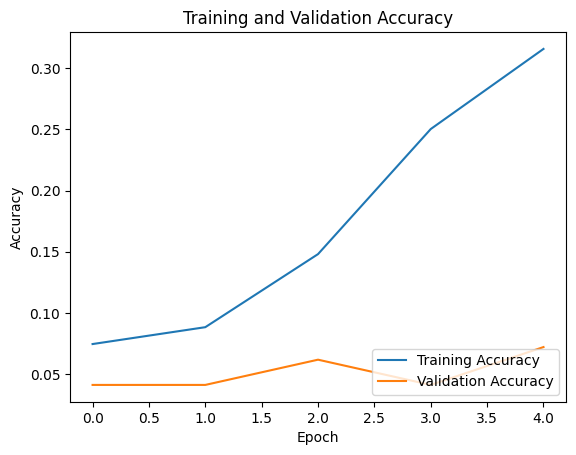

In [ ]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.show()

In [ ]:
model.evaluate(X_test, y_test)
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
y_test_ = np.argmax(y_test, axis=1)

8/8 [==============================] - 3s 257ms/step


In [ ]:
accuracy_sc = accuracy_score(y_pred=y_pred,y_true=y_test_)
f1_sc = f1_score(y_pred=y_pred, y_true=y_test_, average='weighted')
precision_sc = precision_score(y_pred=y_pred, y_true=y_test_, average='weighted', zero_division = 0)
recall_sc = recall_score(y_pred=y_pred, y_true=y_test_, average='weighted')

print(f"Accuracy: {accuracy_sc}")
print(f"F1 Score: {f1_sc}")
print(f"Precision: {precision_sc}")
print(f"Recall: {recall_sc}")

Accuracy: 0.08264462809917356
F1 Score: 0.0621065478521021
Precision: 0.10174108670097975
Recall: 0.08264462809917356
